# DAP3 - Classification 
### John Munar and Jack Witt
We first explore the models themsevles (kNN, Bayes, D-Tree) and find what we observed to be the optimal parameters. Next, we created a data structue of our models with our chosen parameters, and conducted 10-fold cross validation to ensure our models were as accurate as possible. Finally, we conducted basic performance metrics for each of the models, using a confusion matrix, performance report, and ROC curves where applicable.

## Imports

In [70]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# d-tree features
from graphviz import Source
from sklearn.tree import export_graphviz

In [48]:
# Show confusion matrix - written by dr bae
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [11]:
# grab data and split
df = pd.read_csv("../DAP2/processeddata/2018_Financial_Data.csv", index_col=0)
target_cols = ['priceCashFlowRatio', 
               'priceEarningsRatio', 
               'priceEarningsToGrowthRatio', 
               'priceBookValueRatio', 
               'currentRatio', 
               'quickRatio',
               'payoutRatio']
X = df[target_cols]
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## KNN Model 

Highest Accuracy (no-reg): 0.78239608801956 at k = 15
Highest Accuracy (reg): 0.7775061124694377 at k = 15


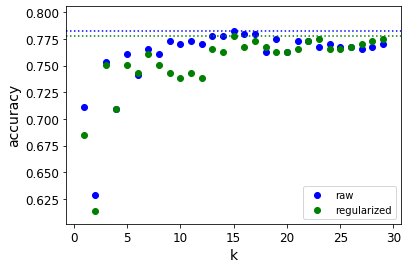

In [12]:
# create and fine tune kNN model
from sklearn.neighbors import KNeighborsClassifier

# find optimal k 
k_range = range(1,30)
scores = []
reg_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    # primary fit
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
    # regularized fit
    knn.fit(X_train_scaled, y_train)
    reg_scores.append(knn.score(X_test_scaled, y_test))
    
# plot scores and find maximum
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores, c='b')
plt.scatter(k_range, reg_scores, c='g')
plt.legend(['raw', 'regularized'])
m = max(scores)
mR = max(reg_scores)
m_index = scores.index(m)+1
m_indexR = reg_scores.index(mR)+1
plt.axhline(y=m, color='b', linestyle=':')
plt.axhline(y=mR, color='g', linestyle=':')
print('Highest Accuracy (no-reg):',m,'at k =',m_index)
print('Highest Accuracy (reg):',mR,'at k =',m_indexR)

Best Partition (no-reg): 0.7835365853658535 training on 80.0 % data
Best Partition (reg): 0.7865853658536586 training on 90.0 % data


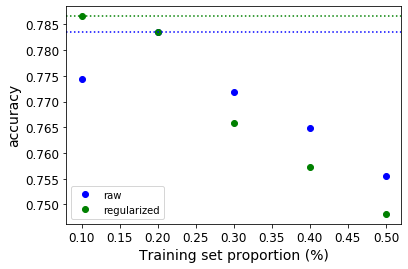

In [13]:
# find optimal testing versus training split size
num_tests = 100 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
knn = KNeighborsClassifier(n_neighbors = m_indexR) # use index of highest accuracy on regularized dataset
plt.figure()

nr = []
r = []
for s in t:
    scores = []
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # normal fit
        knn.fit(X_train, y_train)
        scores.append(knn.score(X_test, y_test))
        # regularized fit 
        knn.fit(X_train_scaled, y_train)
        reg_scores.append(knn.score(X_test_scaled, y_test))
        
    nr.append(np.mean(scores))
    plt.plot(s, nr[-1], 'bo')
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['raw', 'regularized'])
md = max(nr)
mdR = max(r)
md_index = t[nr.index(md)]
md_indexR = t[r.index(mdR)]
plt.axhline(y=md, color='b', linestyle=':')
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (no-reg):',md,'training on',100-md_index*100,'% data')
print('Best Partition (reg):',mdR,'training on', 100-md_indexR*100,'% data')

## Naïve Bayes Model

In [14]:
# re-split and train data for fresh start
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# create and find optimal NB
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train, y_train)
print('Non-Regularized')
print('Accuracy on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

nbclf = GaussianNB().fit(X_train_scaled, y_train)
print('\nRegularized')
print('Accuracy on training set: {:.2f}'
     .format(nbclf.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.2f}'
     .format(nbclf.score(X_test_scaled, y_test)))

Non-Regularized
Accuracy on training set: 0.73
Accuracy on test set: 0.74

Regularized
Accuracy on training set: 0.73
Accuracy on test set: 0.74


Best Partition (reg): 0.7404580152671757 training on 60.0 % data


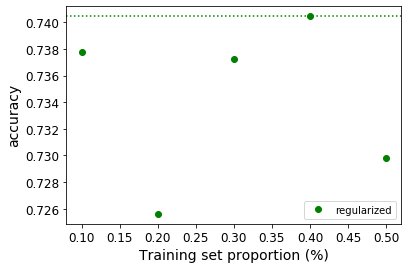

In [16]:
# find optimal testing vs training split size
num_tests = 1000 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
plt.figure()

r = []
for s in t:
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # regularized fit 
        nbclf = GaussianNB().fit(X_train_scaled, y_train)
        reg_scores.append(nbclf.score(X_test_scaled, y_test))
        
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')
    
# plot results
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['regularized'])
mdR = max(r)
md_indexR = t[r.index(mdR)]
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (reg):',mdR,'training on',100-md_indexR*100,'% data')

## Decision Tree (Entropy)

In [18]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Highest Accuracy (no-reg): 0.7652811735941321 at k = 3
Highest Accuracy (reg): 0.7652811735941321 at k = 3


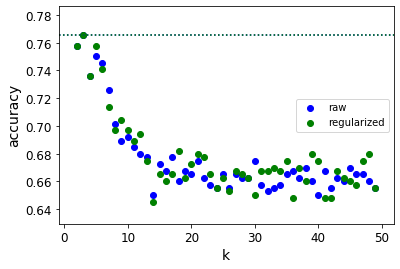

In [19]:
# import and create our decision tree
from sklearn.tree import DecisionTreeClassifier

depth_range = range(2, 50)
scores = []
reg_scores = []

for depth in depth_range:
    tree_entropy = DecisionTreeClassifier(max_depth=depth, criterion='entropy')
    tree_entropy.fit(X_train, y_train)
    
    scores.append(tree_entropy.score(X_test, y_test))
    
    tree_entropy.fit(X_train_scaled, y_train)
    reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
    
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(depth_range, scores, c='b')
plt.scatter(depth_range, reg_scores, c='g')
plt.legend(['raw', 'regularized'])
m = max(scores)
mR = max(reg_scores)
m_index = scores.index(m)+2
m_indexR = reg_scores.index(mR)+2
plt.axhline(y=m, color='b', linestyle=':')
plt.axhline(y=mR, color='g', linestyle=':')
print('Highest Accuracy (no-reg):',m,'at k =',m_index)
print('Highest Accuracy (reg):',mR,'at k =',m_indexR)

Best Partition (reg): 0.7926829268292686 training on 90.0 % data


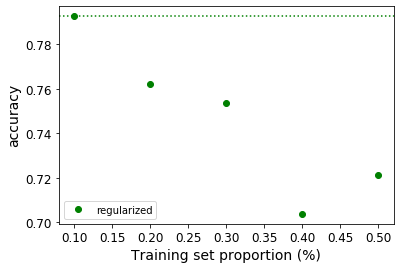

In [21]:
# find optimal testing vs training split size
num_tests = 100 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
plt.figure()

r = []
for s in t:
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # regularized fit and score
        tree_entropy = DecisionTreeClassifier(max_depth=m_indexR, criterion='entropy') # use optimal depth from above cell
        tree_entropy.fit(X_train_scaled, y_train)
        reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
        
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')
    
# plot results
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['regularized'])
mdR = max(r)
md_indexR = t[r.index(mdR)]
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (reg):',mdR,'training on',100-md_indexR*100,'% data')

## Decision Tree (Gini)

In [22]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Highest Accuracy (no-reg): 0.78239608801956 at k = 2
Highest Accuracy (reg): 0.78239608801956 at k = 2


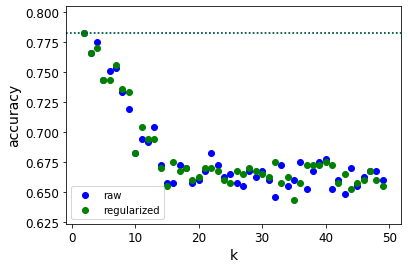

In [23]:
# find optimal parameters
scores = []
reg_scores = []
for depth in depth_range:
    tree_entropy = DecisionTreeClassifier(max_depth=depth, criterion='gini')
    tree_entropy.fit(X_train, y_train)
    
    scores.append(tree_entropy.score(X_test, y_test))
    
    tree_entropy.fit(X_train_scaled, y_train)
    reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
    
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(depth_range, scores, c='b')
plt.scatter(depth_range, reg_scores, c='g')
plt.legend(['raw', 'regularized'])
m = max(scores)
mR = max(reg_scores)
m_index = scores.index(m)+2
m_indexR = reg_scores.index(mR)+2
plt.axhline(y=m, color='b', linestyle=':')
plt.axhline(y=mR, color='g', linestyle=':')
print('Highest Accuracy (no-reg):',m,'at k =',m_index)
print('Highest Accuracy (reg):',mR,'at k =',m_indexR)

Best Partition (reg): 0.7865853658536586 training on 90.0 % data


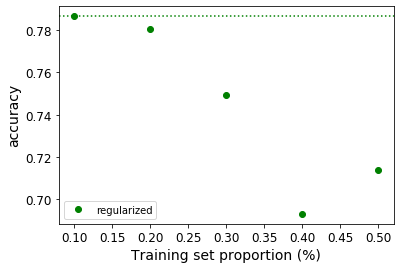

In [24]:
# find optimal testing vs training split size
num_tests = 100 # testing threshold 
t = [0.5, 0.4, 0.3, 0.2, 0.1]
plt.figure()

r = []
for s in t:
    reg_scores = []
    for i in range(num_tests):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = s, random_state=0)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # regularized fit and score
        tree_entropy = DecisionTreeClassifier(max_depth=m_indexR, criterion='gini') # use optimal depth from above cell
        tree_entropy.fit(X_train_scaled, y_train)
        reg_scores.append(tree_entropy.score(X_test_scaled, y_test))
        
    r.append(np.mean(reg_scores))
    plt.plot(s, r[-1], 'bo', c='g')
    
# plot results
plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');
plt.legend(['regularized'])
mdR = max(r)
md_indexR = t[r.index(mdR)]
plt.axhline(y=mdR, color='g', linestyle=':')
print('Best Partition (reg):',mdR,'training on',100-md_indexR*100,'% data')

# Data Structure of our Models 
Now that we have our optimal parameters, we can begin applying our 10-fold cv and conducting various model evaluations 

## K-Fold Cross Validation

In [27]:
# create dict of classifiers 
cls = {
    'KNN_15'     : { 'optimalPartition' : 0.9, 'model' : KNeighborsClassifier(n_neighbors = 15) },
    'NB'         : { 'optimalPartition' : 0.6, 'model' : GaussianNB() },
    'DT_entropy' : { 'optimalPartition' : 0.9, 'model' : DecisionTreeClassifier(max_depth=3, criterion='entropy') },
    'DT_gini'    : { 'optimalPartition' : 0.9, 'model' : DecisionTreeClassifier(max_depth=2, criterion='gini') }
}

In [58]:
# create cv 
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=None, shuffle=True) 

# average out classification reports? 
def combineReports(name, reports):
    avg_report = {'0': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, '1': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 'accuracy': 0, 'macro avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}, 'weighted avg': {'precision': 0, 'recall': 0, 'f1-score': 0, 'support': 0}}
    
    for report in reports:
        for outer_key in report.keys():
            if outer_key == 'accuracy':
                avg_report['accuracy'] += report['accuracy']
                continue
            for inner_key in report[outer_key].keys():
                avg_report[outer_key][inner_key] += report[outer_key][inner_key]

    for outer_key in avg_report.keys():
            if outer_key == 'accuracy':
                avg_report['accuracy'] /= len(reports)
                continue
            for inner_key in avg_report[outer_key].keys():
                avg_report[outer_key][inner_key] /= len(reports)
    
    printDf = pd.DataFrame(avg_report).transpose()
    print(str(name),'\n',printDf,'\n')

# apply 10-fold cv to all of the models and find optimal data partition
for cl in cls: 
    reports = []
    # re-split the data for each new partition 
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=cls[cl]['optimalPartition'], random_state=0)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # apply our cv 
    for train_index, val_index in kf.split(X_train_scaled):
        cv_X_train   = X_train.iloc[train_index]
        cv_X_val    = X_train.iloc[val_index]
        cv_y_train   = y_train.iloc[train_index]
        cv_y_val    = y_train.iloc[val_index]
       
        cls[cl]['model'].fit(cv_X_train, cv_y_train) # ask about how to persist the best model 
        y_pred = cls[cl]['model'].predict(cv_X_test)
        
        report = classification_report(cv_y_test, y_pred, output_dict=True)
        reports.append(report)
        
    # print average report after cv applied to model
    combineReports(cl, reports)

KNN_15 
               precision    recall  f1-score     support
0              0.549890  0.286111  0.375789   36.000000
1              0.799762  0.924324  0.857512  111.000000
accuracy       0.768027  0.768027  0.768027    0.768027
macro avg      0.674826  0.605218  0.616650  147.000000
weighted avg   0.738569  0.768027  0.739539  147.000000 

NB 
               precision    recall  f1-score     support
0              0.421710  0.386111  0.402986   36.000000
1              0.806403  0.828829  0.817439  111.000000
accuracy       0.720408  0.720408  0.720408    0.720408
macro avg      0.614057  0.607470  0.610213  147.000000
weighted avg   0.712193  0.720408  0.715940  147.000000 

DT_entropy 
               precision    recall  f1-score     support
0              0.533580  0.177778  0.260876   36.000000
1              0.780786  0.948649  0.856352  111.000000
accuracy       0.759864  0.759864  0.759864    0.759864
macro avg      0.657183  0.563213  0.558614  147.000000
weighted avg   0.

In [59]:
# using most common optimal partition, create split and learn models 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=0) 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train the models on the same data
for cl in cls: 
    cls[cl]['model'].fit(X_train_scaled, y_train)

## Evaluation of our Models 

KNN_15 
 [[ 11  24]
 [ 11 118]]


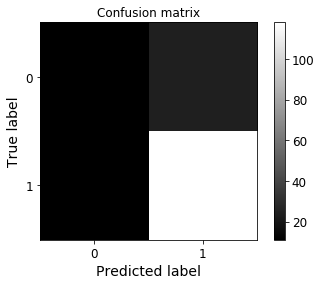

NB 
 [[ 13  22]
 [ 21 108]]


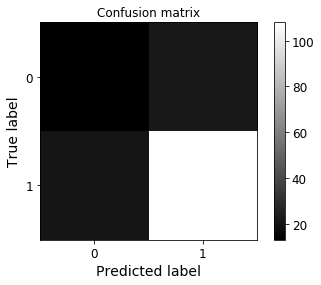

DT_entropy 
 [[  5  30]
 [  4 125]]


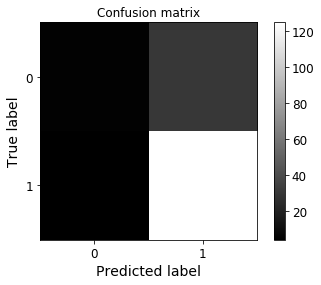

DT_gini 
 [[  4  31]
 [  4 125]]


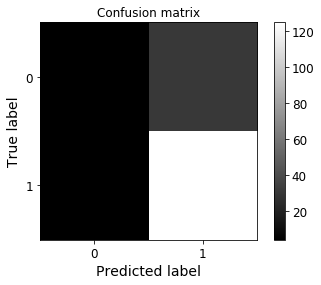

In [61]:
# confusion matrix 
for cl in cls: 
    y_pred = cls[cl]['model'].predict(X_test_scaled)

    # create and plot a confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(cl,'\n',confusion_mat)
    plot_confusion_matrix(confusion_mat, 2)

KNN_15 Accuracy =  0.7127353266888151


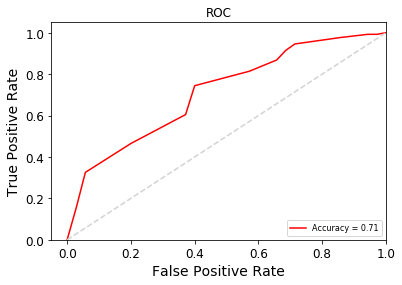

NB Accuracy =  0.6952380952380952


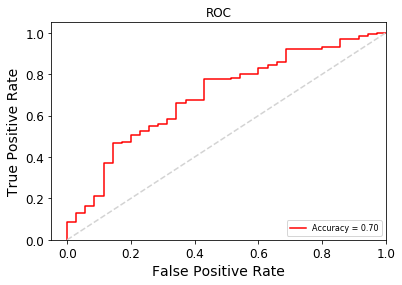

DT_entropy Accuracy =  0.6794019933554818


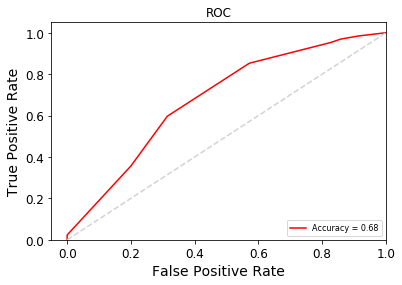

DT_gini Accuracy =  0.6723145071982282


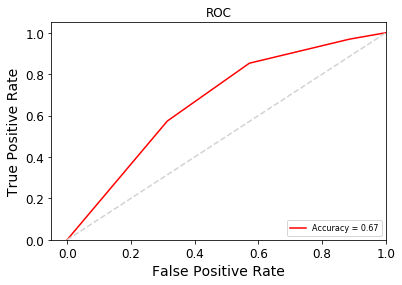

In [69]:
# roc curves 
for cl in cls: 
    y_pred = cls[cl]['model'].predict_proba(X_test_scaled)

    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred[:,1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(cl,'Accuracy = ', roc_auc)

    # Plotting
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate, c='r', label=('Accuracy = %0.2f'%roc_auc))
    plt.legend(loc='lower right', prop={'size':8})
    plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
    plt.xlim([-0.05,1.0])
    plt.ylim([0.0,1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

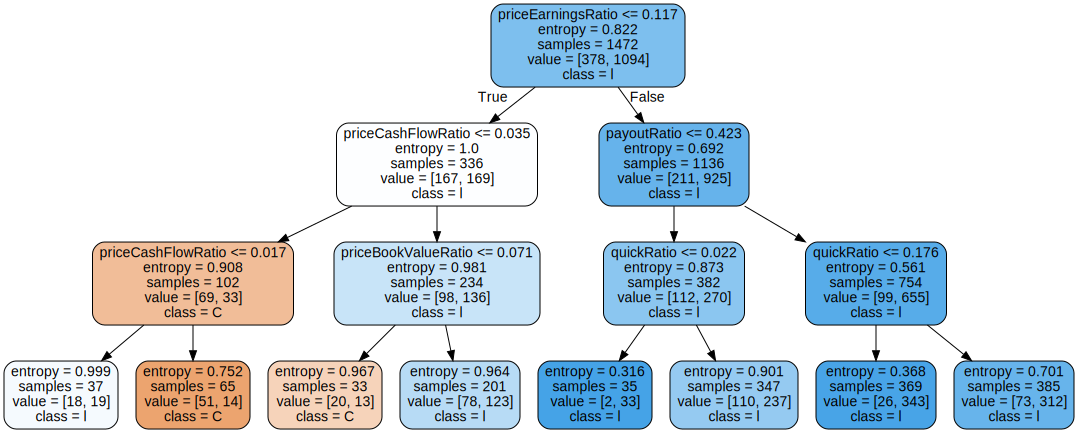

In [78]:
# decision trees important features (entropy)
export_graphviz(
        cls['DT_entropy']['model'],
        out_file="entropy.dot",
        feature_names=target_cols,
        class_names='Class',
        rounded=True,
        filled=True
    )
Source.from_file("entropy.dot")

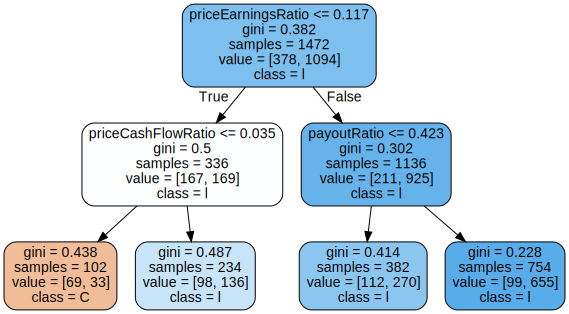

In [79]:
# decision trees important features (gini)
export_graphviz(
        cls['DT_gini']['model'],
        out_file="gini.dot",
        feature_names=target_cols,
        class_names='Class',
        rounded=True,
        filled=True
    )
Source.from_file("gini.dot")

## Summary and Discussion 

It appears that the kNN model performs slightly better than the other three, with Naive Bayes and the Decision Trees performing about the same on average. They all have a very similar accuracy and performance - indicated by the confusion matrices and ROC curves. From our performance results (classification reports) we can see that class 0 has much lower precision and recall as compared to class 1, with recall being the lower of the two. We believe this is due to the skew of positive to negative classes within our dataset.  

When conducting evaluation, we don't use the optimal partition - the model's prefferred size of training data - and thus our models may have a slightly increased accuracy in practice. We found the optimal parameters to be: kNN - 15 neighbors, Decision Tree (Entropy) - Depth of 3, and Decision Tree (Gini) - Depth of 2. It all cases, it appears the priceEarningsRatio is the most important feature, given it is the root node of both trees, followed by proceCashFlowRatio and payoutRatio. 

In conclusion, we feel our models performed decently given the skew of the data. In order to increase performance, we would have to investigate other relevant attributes with regards to stock trading, performing feature selection and elimination on our existing attributes, and balance or re-sample our dataset.  
